In [2]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Parameters
n = 50
C = 10
T = 9.26
M = 30
sT = 3

# Factors

# FME_Exponential
# p = [0.1,0.2,0.3,0.4,0.5]
# K = [9,10,11,12,13,14,15,16,17,18,19,20,21]

# FME_Exponential_2
p = [0.1,0.2,0.3]
K = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]


# CSV name
# csv_name = "FME_Exponential"
csv_name = "FME_Exponential_2"

In [4]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "scalar"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_17544\131608406.py:1: DtypeWarning: Columns (2,3,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [5]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: p/K
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]


CSV_Scalar = CSV[CSV["type"] == "scalar"]

# S: Mean Service Time (t_S) [LocalSink] 
Exp_S = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.localSink")]
Exp_S = Exp_S[Exp_S["name"] == "totalServiceTime:mean"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:mean"]

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:mean"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "S": Exp_S,
    "W": Exp_W,
    "TW": Exp_TW
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the configuration p_K
    config[row["run"].split("-")[2]] = row["attrvalue"].replace("/", "_")


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is the configuration p_K
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific configuration

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"

            # For the current run we save the PI value of the queue string (e.g. Q0)
            PI[key][config[run]][run][string] = float(row["value"]) 
        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            # For the current run we save the PI value of the overall system
            PI[key][config[run]][run] = float(row["value"])

# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not relative to 
            # that specific configuration
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [6]:

# E[W] = E[R]- E[t_S]

# E[R] = E[W] + E[t_S]
    
# We add a new Performance Index to PI_df
PI_df["R"] = {}

# For each configuration we compute the value of E[R] = E[W] + E[t_S]
for config in PI_df["W"]:
    # This is a sum of two DataFrames element-wise
    PI_df["R"][config] = PI_df["W"][config] + PI_df["S"][config]


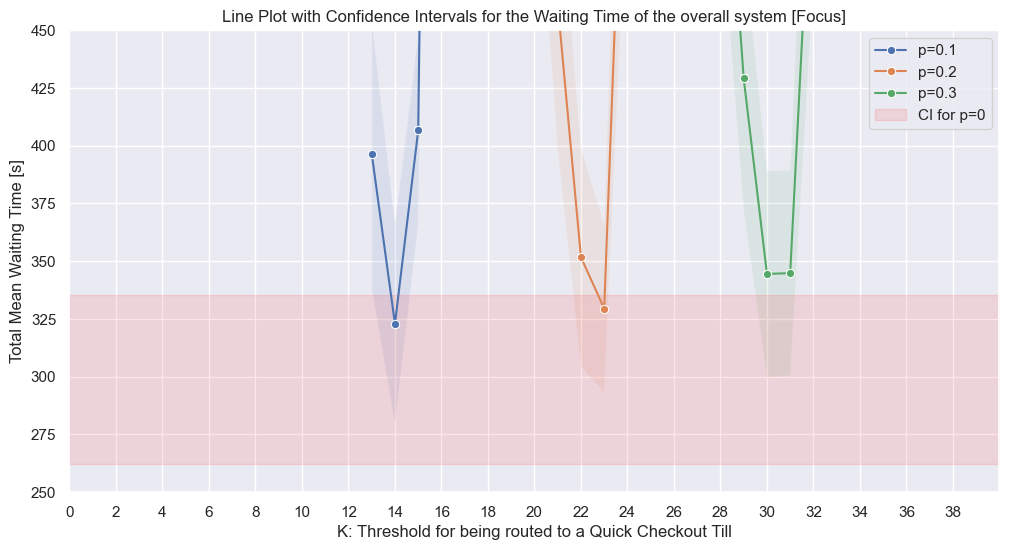

In [7]:
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(250, 450)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Total Mean Waiting Time [s]')

plt.legend()
plt.show()

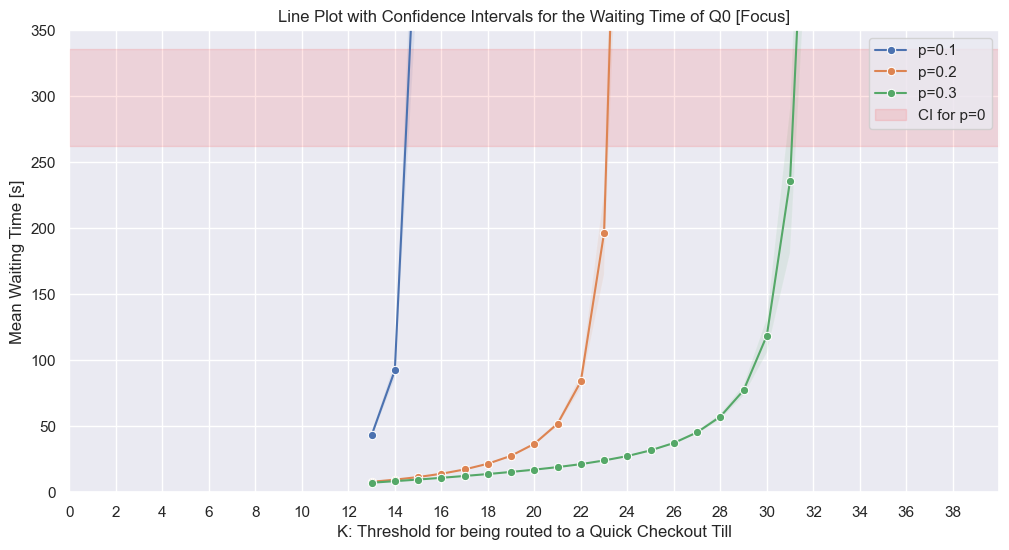

In [8]:
# Mean Waiting Time for Q0
# Q0 is a quick checkout till in each configuration (p=0.1, p=0.2, p=0.3)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q0"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q0"].mean() - (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q0"].mean() + (1.96 * (PI_df[pi][couple]["Q0"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 350)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q0 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

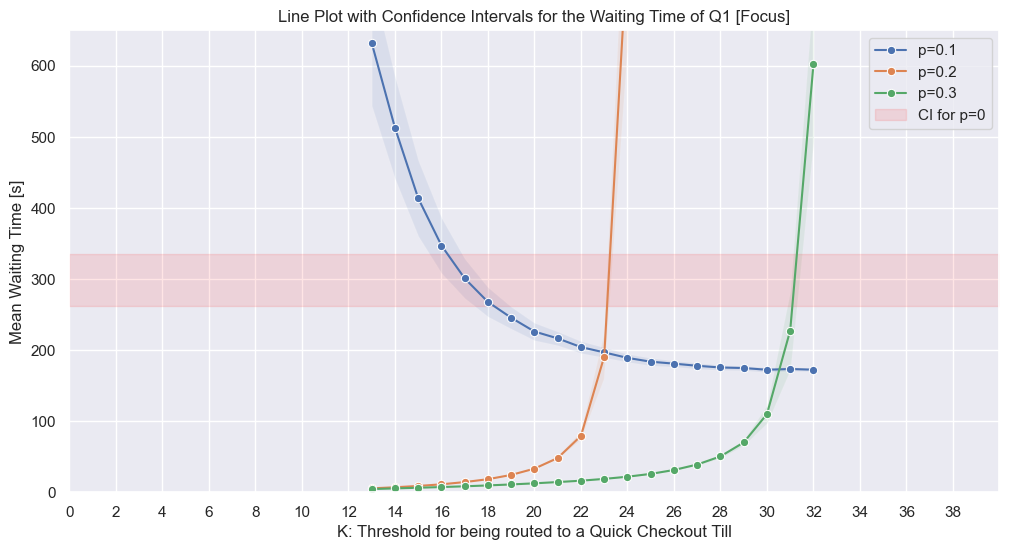

In [9]:
# Mean Waiting Time for Q1
# Q1 is a normal checkout till for p=0.1
# Q1 is a quick checkout till for p=0.2
# Q1 is a quick checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q1"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q1"].mean() - (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q1"].mean() + (1.96 * (PI_df[pi][couple]["Q1"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 650)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q1 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

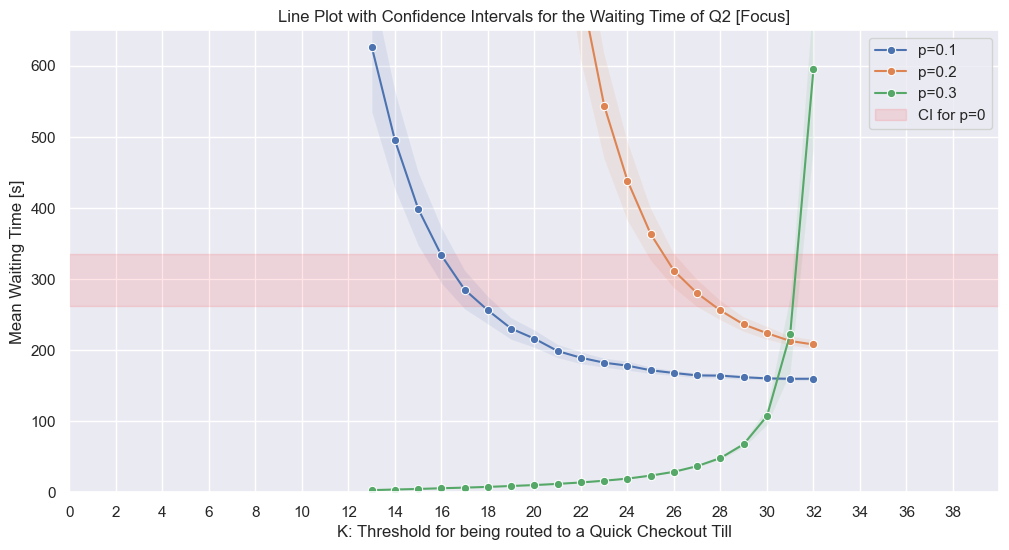

In [10]:
# Mean Waiting Time for Q2
# Q2 is a normal checkout till for p=0.1
# Q2 is a normal checkout till for p=0.2
# Q2 is a quick checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q2"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q2"].mean() - (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q2"].mean() + (1.96 * (PI_df[pi][couple]["Q2"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 650)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q2 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

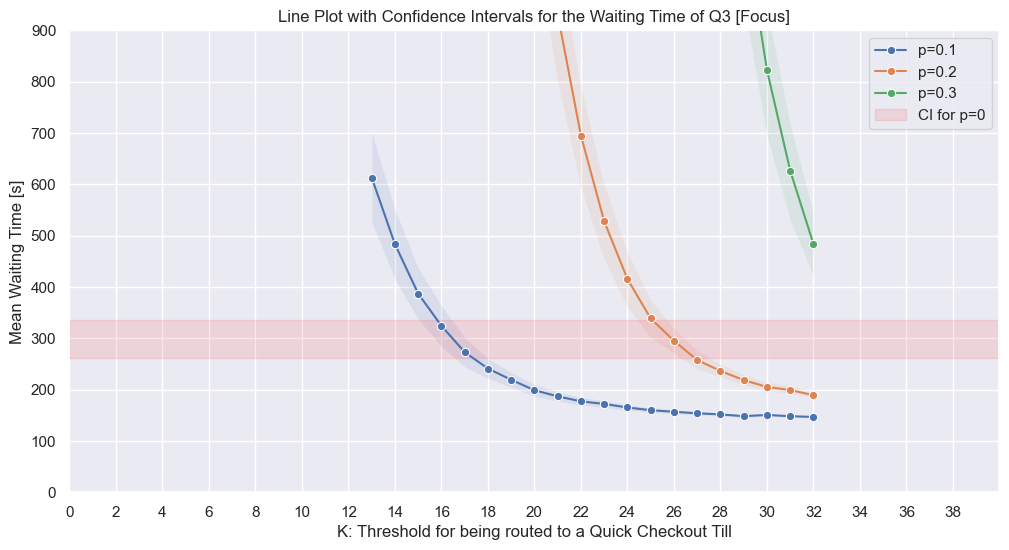

In [11]:
# Mean Waiting Time for Q3
# Q3 is a normal checkout till for p=0.1
# Q3 is a normal checkout till for p=0.2
# Q3 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q3"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q3"].mean() - (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q3"].mean() + (1.96 * (PI_df[pi][couple]["Q3"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q3 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

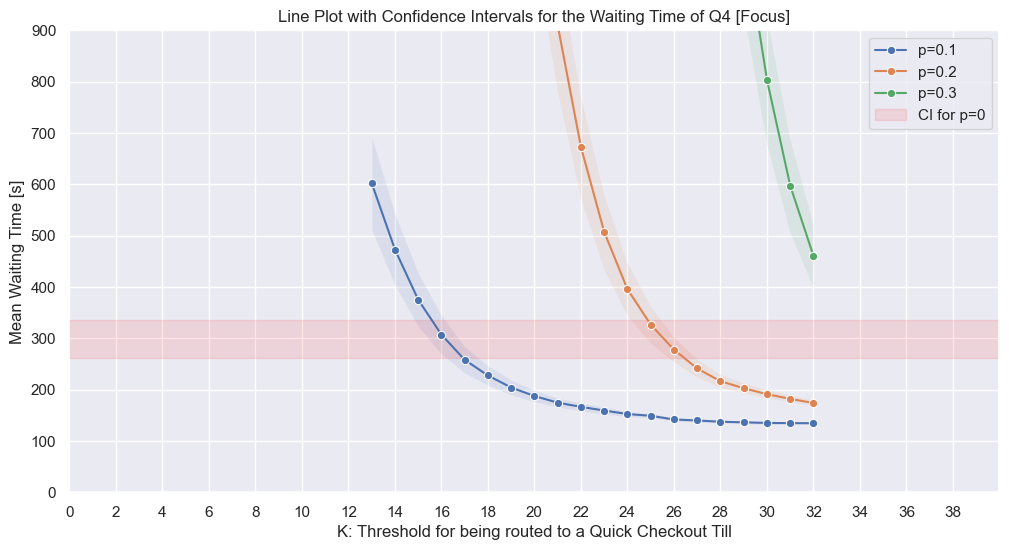

In [12]:
# Mean Waiting Time for Q4
# Q4 is a normal checkout till for p=0.1
# Q4 is a normal checkout till for p=0.2
# Q4 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q4"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q4"].mean() - (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q4"].mean() + (1.96 * (PI_df[pi][couple]["Q4"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q4 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

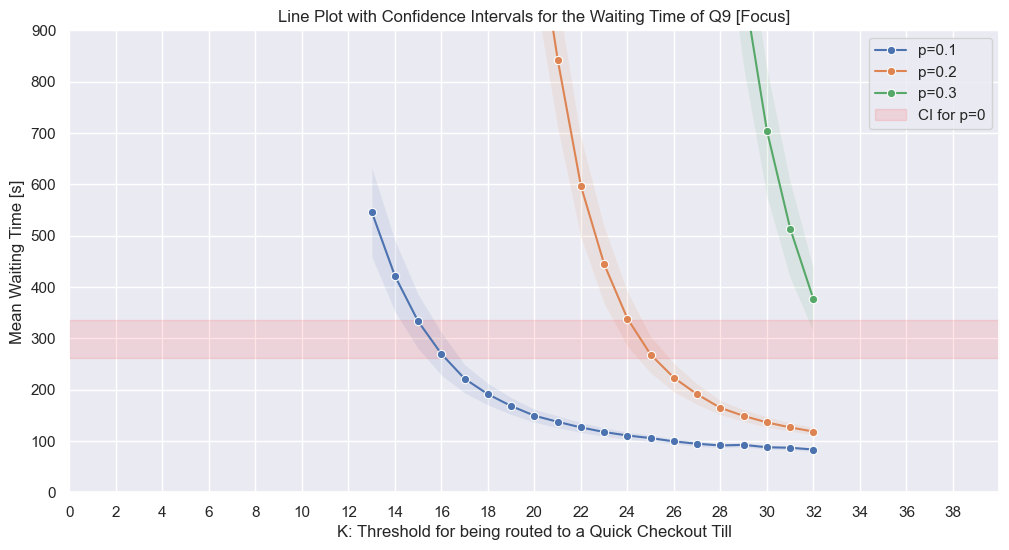

In [13]:
# Mean Waiting Time for Q9
# Q9 is a normal checkout till for p=0.1
# Q9 is a normal checkout till for p=0.2
# Q9 is a normal checkout till for p=0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["Q9"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["Q9"].mean() - (1.96 * (PI_df[pi][couple]["Q9"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["Q9"].mean() + (1.96 * (PI_df[pi][couple]["Q9"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
# plt.fill_between(y=[262.118, 335.403], alpha=0.1)
# plt.axhline(y=262.118, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=335.403, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([262.118, 335.403], 0, 40, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
plt.xlim(0, 40)  
# Set the y-axis limits
plt.ylim(0, 900)  

plt.title('Line Plot with Confidence Intervals for the Waiting Time of Q9 [Focus]')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

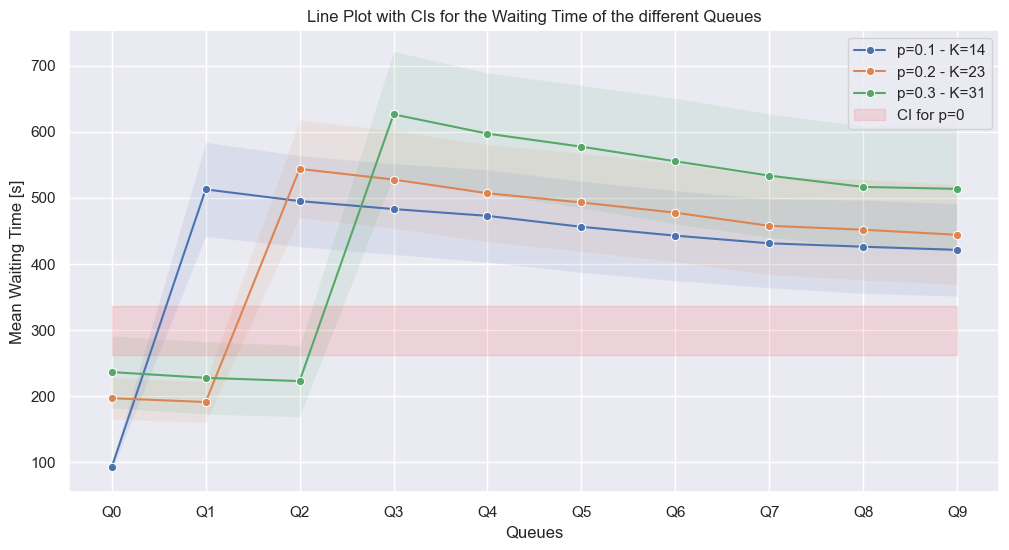

In [25]:
# Plotting the Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "W"

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        ci_lb.append(PI_df[pi][cc][q].mean() - (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][cc][q].mean() + (1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(Q, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=Q, y=y_W, marker='o', label=f"p={cc.split('_')[0]} - K={cc.split('_')[1]}")


# Mean Value in the case of p = 0 (and K=0) 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
plt.fill_betweenx([262.118, 335.403], 0, 9, color='red', alpha=0.1, label="CI for p=0")

# plt.xticks(np.arange(0, 40, 2))

# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
# plt.ylim(0, 900)  

plt.title('Line Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()

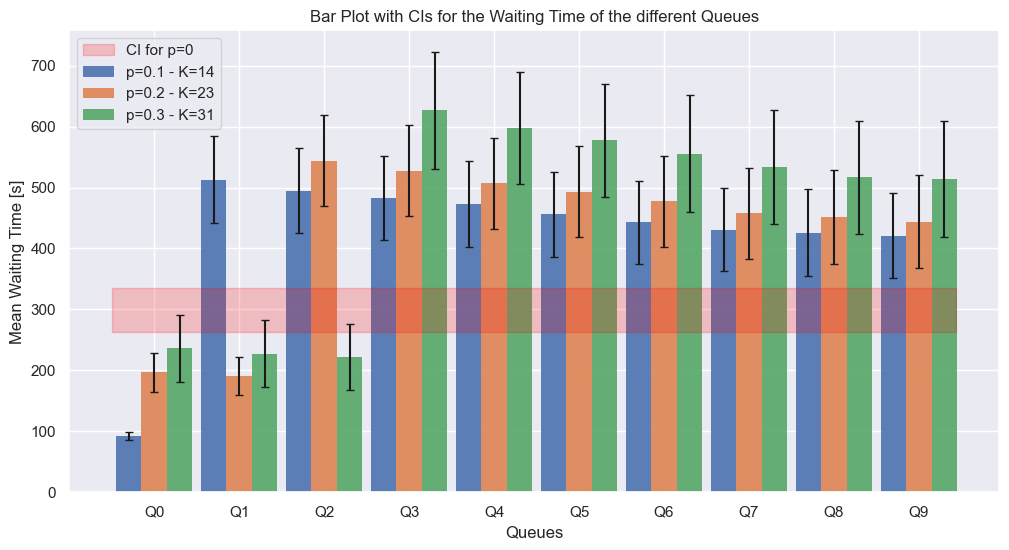

In [82]:
# (BarPlot) Mean Waiting Time for each queue in the following configurations:
configurations = ["0.1_14", "0.2_23", "0.3_31"]

# width of the bars
barWidth = 0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))


# Performance Index
pi = "W"

rx = np.arange(len(Q))

for cc in configurations:

    # We save in y_W all the values for the current cc
    y_W = []

    # Confidence Interval Bounds
    y_err = []

    for q in Q:

        y_W.append(PI_df[pi][cc][q].mean())

        y_err.append(1.96 * (PI_df[pi][cc][q].std() / math.sqrt(n)))

    plt.bar(rx, y_W, width = barWidth, edgecolor = 'black', yerr=y_err, capsize=3, label=f"p={cc.split('_')[0]} - K={cc.split('_')[1]}", lw=0, alpha=0.9)
    rx = [x + barWidth for x in rx]


# Mean Value in the case of p = 0 (and K=0) 298.760315255702
# Confidence Interval Bounds: LB: 262.11756154619184  UB: 335.4030689652121
plt.fill_betweenx([262.118, 335.403], -0.2, 9.74, color='red', alpha=0.2, label="CI for p=0")


# Set the x-axis limits
# plt.xlim(0, 40)  
# Set the y-axis limits
# plt.ylim(0, 900)  

plt.xticks([r + barWidth for r in range(len(Q))], Q)
plt.title('Bar Plot with CIs for the Waiting Time of the different Queues')
plt.xlabel('Queues')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()